# ResNet-50 Pruning Experiments

Get familiar with distiller using pre-trained ResNet-50 model.<br>

## Table of Contents

1. [Load ResNet-50 Pre-trained Model](#Load ResNet-50 Pre-trained Model)
2. [Visualize ResNet-50](#Visualize ResNet-50)
3. [Print a summary of the statistics of the model attributes using ```model_performance_summary```](#Print a summary of the statistics of the model attributes using ```model_performance_summary```)<br>
    3.1. [Display some information about the layers](#Display-some-information-about-the-layer-types)<br>
    3.2. [Compare weights footprint to feature-map footprint](#Compare-weights-footprint-to-feature-map-footprint)<br>
    3.3. [Compare data footprint to compute (MACs)](#Compare-data-footprint-to-compute-(MACs)
4. [Filter L1-norm](#Filter-L1-norm)
5. [Sensitivity Analysis](#Sensitivity Analysis)
5. [References](#References)

In [1]:
# Relative import of code from distiller, w/o installing the package
import os
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
    
from distiller.model_summaries import *
from models import create_model
from apputils import *
import torch
import torchvision
import qgrid

# Load some common jupyter code
%run distiller_jupyter_helpers.ipynb
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout

# Some models have long node names and require longer lines
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def pretty_int(i):
    return "{:,}".format(i)

## Load ResNet-50 Pre-trained Model


In [2]:
exp_dir = os.getcwd()
dataset = 'imagenet'
arch = 'resnet50'
model = create_model(pretrained=True, dataset=dataset, arch=arch, parallel=False)

## Visualize ResNet-50
To visualize PyTorch models, [PyTorchViz](https://github.com/szagoruyko/pytorchviz) is used.  This tools is very handy in a quick view of the model but it is not as clean as Keras and Caffe tools.<br>

### Using Dummy Variable
Here we will visualize the network using a dummy input.

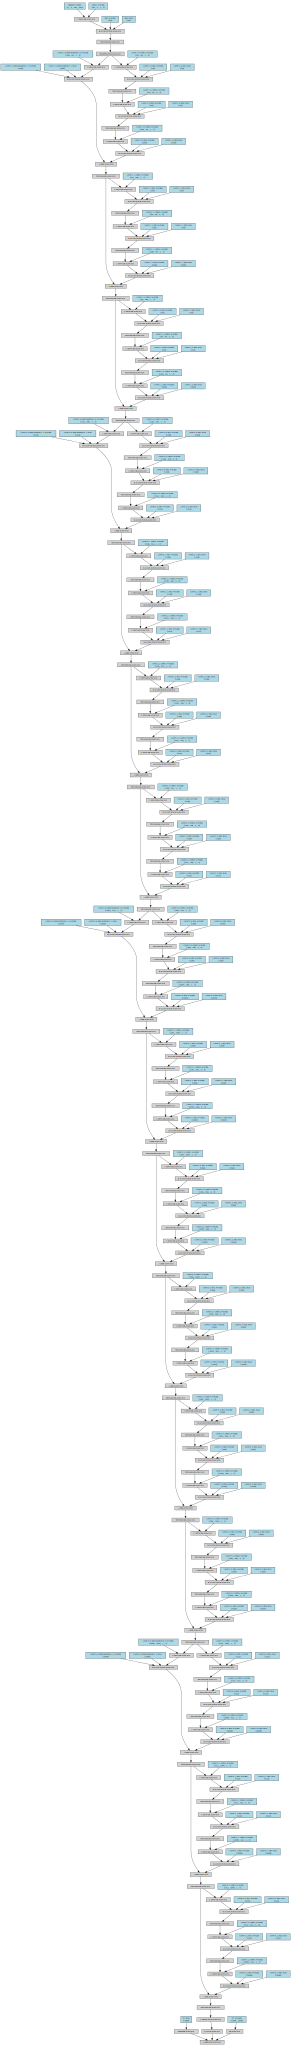

In [3]:
from torchviz import make_dot, make_dot_from_trace
dummy_input = Variable(torch.randn(1, 3, 224, 224), requires_grad=True)
pred = model(dummy_input)
make_dot( pred, params=dict(list(model.named_parameters()) + [('dummy_input', dummy_input)]))

### Using Test Image
Here we will visualize the network using the hot dog test image.

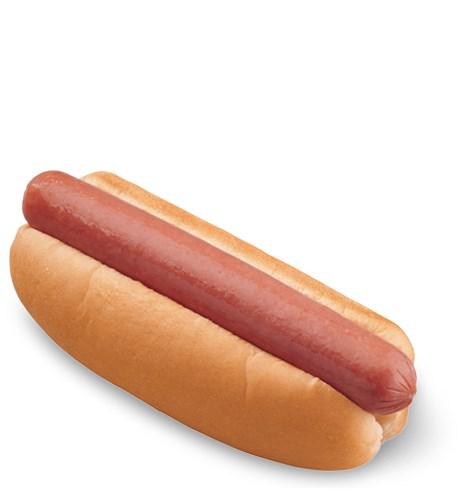

In [4]:
os.chdir(exp_dir)
from PIL import Image
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
])
img_pil = Image.open("hot_dog.jpg")
img_pil

Pre-processing is necessary before visualizing the image.

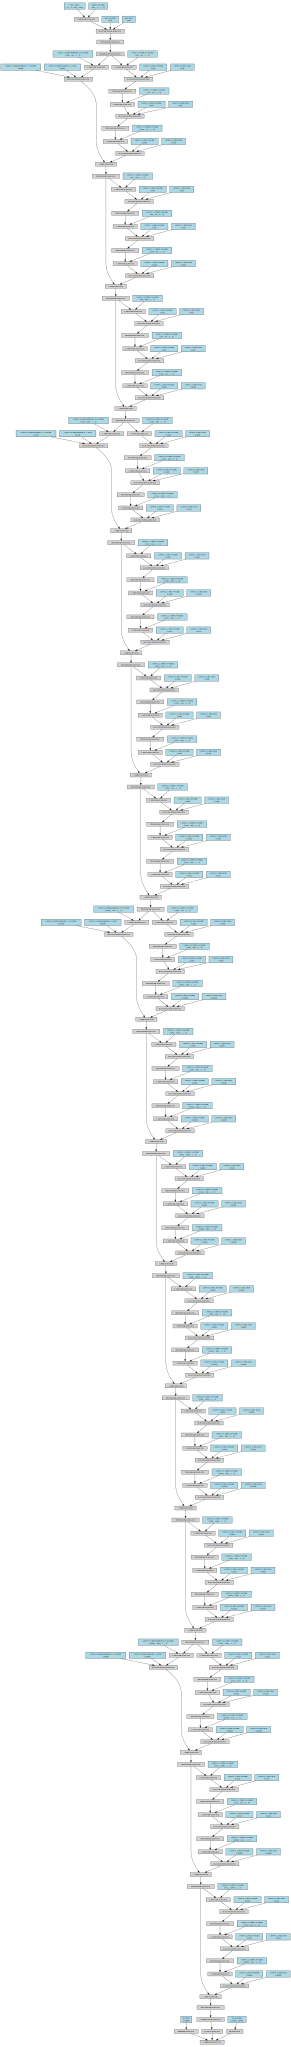

In [5]:
# Pre-process image
img_tensor = preprocess(img_pil)
img_tensor.unsqueeze_(0)

# Visualize network
test_img = Variable(img_tensor, requires_grad=True)
pred = model(test_img)
make_dot( pred, params=dict(list(model.named_parameters()) + [('test_img', test_img)]))

## Print a summary of the statistics of the model attributes using ```model_performance_summary```

Distiller generates several different summary reports, which are returned as Pandas dataframes which you can slice, dice and sort using Pandas' rich API.<br>
<br>
MACs are multiply-accumulate operations: a MAC unit computes the product of two elements and adds the product to an accumulator.  The MACs reported by distiller.model_performance_summary are for direct GEMM (General Matrix-Matrix Multiplication) and convolution.  Different hardware uses specific algorithms at different times.  For example, [Intel's MKL-DNN](https://intel.github.io/mkl-dnn/) uses [Winograd](https://arxiv.org/pdf/1509.09308.pdf) for 3x3 convolutions.  As another example, [convolutions are sometimes computed using GEMM](https://petewarden.com/2015/04/20/why-gemm-is-at-the-heart-of-deep-learning/) for increased utilization of vectorized hardware.<br>


<br>
In the example below, we display some statistics about the sizes and shapes of the feature-maps and weight tensors, etc.

The syntax for the ```model_performance_summary``` function is ```distiller.model_performance_summary(model, dummy_input, batch_size=1)```

In [6]:
df = distiller.model_performance_summary(model, test_img, 1)
df

,Name,Type,Attrs,IFM,IFM volume,OFM,OFM volume,Weights volume,MACs
0,conv1,Conv2d,"k=(7, 7)","(1, 3, 224, 224)",150528,"(1, 64, 112, 112)",802816,9408,118013952
1,layer1.0.conv1,Conv2d,"k=(1, 1)","(1, 64, 56, 56)",200704,"(1, 64, 56, 56)",200704,4096,12845056
2,layer1.0.conv2,Conv2d,"k=(3, 3)","(1, 64, 56, 56)",200704,"(1, 64, 56, 56)",200704,36864,115605504
3,layer1.0.conv3,Conv2d,"k=(1, 1)","(1, 64, 56, 56)",200704,"(1, 256, 56, 56)",802816,16384,51380224
4,layer1.0.downsample.0,Conv2d,"k=(1, 1)","(1, 64, 56, 56)",200704,"(1, 256, 56, 56)",802816,16384,51380224
5,layer1.1.conv1,Conv2d,"k=(1, 1)","(1, 256, 56, 56)",802816,"(1, 64, 56, 56)",200704,16384,51380224
6,layer1.1.conv2,Conv2d,"k=(3, 3)","(1, 64, 56, 56)",200704,"(1, 64, 56, 56)",200704,36864,115605504
7,layer1.1.conv3,Conv2d,"k=(1, 1)","(1, 64, 56, 56)",200704,"(1, 256, 56, 56)",802816,16384,51380224
8,layer1.2.conv1,Conv2d,"k=(1, 1)","(1, 256, 56, 56)",802816,"(1, 64, 56, 56)",200704,16384,51380224
9,layer1.2.conv2,Conv2d,"k=(3, 3)","(1, 64, 56, 56)",200704,"(1, 64, 56, 56)",200704,36864,115605504


In [7]:
# You can display summaries using several backends, and each has its advantages and disadvantages, so you will want to use them in different situations.
print("Weights shapes, sizes and statistics (showing only FC and convolution layers):")
print("\tTotal IFM footprint (elements): " + "{:,}".format(df['IFM volume'].sum()))
print("\tTotal OFM footprint (elements): " + "{:,}".format(df['OFM volume'].sum()))
print("\tTotal weights footprint (elements): " + "{:,}".format(df['Weights volume'].sum()))
print("\tTotal MACs: " + "{:,}".format(df['MACs'].sum()))

Weights shapes, sizes and statistics (showing only FC and convolution layers):
	Total IFM footprint (elements): 10,664,448
	Total OFM footprint (elements): 11,114,984
	Total weights footprint (elements): 25,502,912
	Total MACs: 4,089,184,256


### Display some information about the layers
Using Pandas for model statistics provides a painless way to query 2nd level details about the model.  Here we separate statistics by ```df['Type']```

In [8]:
for dt in df['Type'].unique():
    dt_data = df[df['Type'] == dt]
    dt_len = len(dt_data)
    print("There are {} {} layers with {} MACs".format(dt_len, dt, pretty_int(dt_data['MACs'].sum())))

There are 53 Conv2d layers with 4,087,136,256 MACs
There are 1 Linear layers with 2,048,000 MACs


Here we separate statistics by ```df['Attrs']``` (kernel size)

In [9]:
conv7x7 = df[df['Attrs'] == 'k=(7, 7)']
conv3x3 = df[df['Attrs'] == 'k=(3, 3)']
conv1x1 = df[df['Attrs'] == 'k=(1, 1)']

print("There are %d Conv(7,7) layers with total MACs = %s" % (len(conv7x7), pretty_int(conv7x7['MACs'].sum())))
print("There are %d Conv(3,3) layers with total MACs = %s" % (len(conv3x3), pretty_int(conv3x3['MACs'].sum())))
print("There are %d Conv(1,1) layers with total MACs = %s" % (len(conv1x1), pretty_int(conv1x1['MACs'].sum())))

There are 1 Conv(7,7) layers with total MACs = 118,013,952
There are 16 Conv(3,3) layers with total MACs = 1,849,688,064
There are 36 Conv(1,1) layers with total MACs = 2,119,434,240


Here we separate statistics by ```df['Weights volume']```

In [10]:
for ws in df['Weights volume'].unique():
    ws_len = len(df[df['Weights volume'] == ws])
    print("{} layer(s) with {} MACs each (total: {} MACs)".format(ws_len, pretty_int(ws),  pretty_int(ws*ws_len)))

1 layer(s) with 9,408 MACs each (total: 9,408 MACs)
1 layer(s) with 4,096 MACs each (total: 4,096 MACs)
3 layer(s) with 36,864 MACs each (total: 110,592 MACs)
6 layer(s) with 16,384 MACs each (total: 98,304 MACs)
1 layer(s) with 32,768 MACs each (total: 32,768 MACs)
4 layer(s) with 147,456 MACs each (total: 589,824 MACs)
7 layer(s) with 65,536 MACs each (total: 458,752 MACs)
2 layer(s) with 131,072 MACs each (total: 262,144 MACs)
6 layer(s) with 589,824 MACs each (total: 3,538,944 MACs)
11 layer(s) with 262,144 MACs each (total: 2,883,584 MACs)
2 layer(s) with 524,288 MACs each (total: 1,048,576 MACs)
3 layer(s) with 2,359,296 MACs each (total: 7,077,888 MACs)
5 layer(s) with 1,048,576 MACs each (total: 5,242,880 MACs)
1 layer(s) with 2,097,152 MACs each (total: 2,097,152 MACs)
1 layer(s) with 2,048,000 MACs each (total: 2,048,000 MACs)


### Compare weights footprint to feature-map footprint

Memory footprint, bandwidth and throughput are different concepts.  ***Footprint*** is the size (amount of memory) required to store a piece of data (e.g. measured as number of bytes).  ***Bandwidth*** is the rate at which data can be read or written (stored) from/to memory by different hardware (e.g. measured as bytes/sec).  ***Throughput*** is a measure of the data that actually moves (read/stored) in a period of time (bytes/sec).<br>
Because the amount of data required for a typical neural-network operation is often larger than the available working memory of the compute hardware (e.g. CPU registers and cache), data often needs to be sliced into tiles (blocks).  The sizes of the tiles, together with the memory access pattern and the compute algorithm, determine the total amount of data that needs to move around (read/stored).  Because of this hardware dependency, we provide below information regarding memory footprint and not throughput.

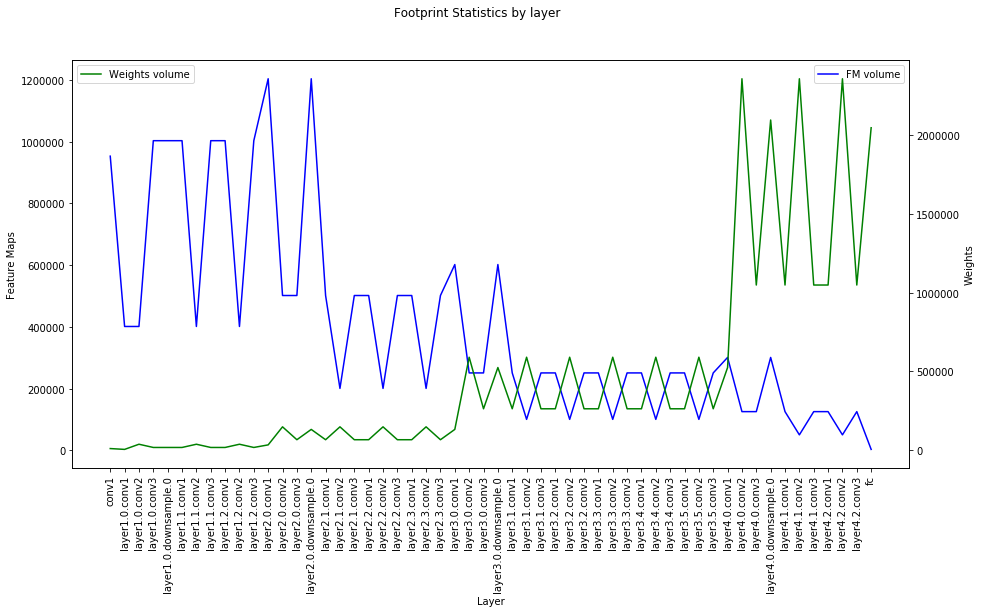

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7.5))
fig.suptitle("Footprint Statistics by layer")
ax.set_ylabel("Feature Maps")
ax.set_xlabel("Layer")
ax2 = ax.twinx()
ax2.set_ylabel("Weights")
ax.set_xticklabels(df.Name, rotation=90);

df["FM volume"] = df["OFM volume"] + df["IFM volume"]
df[["Name","FM volume"]].plot(ax=ax, xticks=range(len(df.index)), style="b-", rot=90)
df[["Name","Weights volume"]].plot(ax=ax2, style="g-", use_index=True, rot=90);


### Compare data footprint to compute (MACs)

We measure Footprint in number of elements, not bytes.  If, for example, the elements data type is FP32, then the real footprint is 4x the reported footprint.

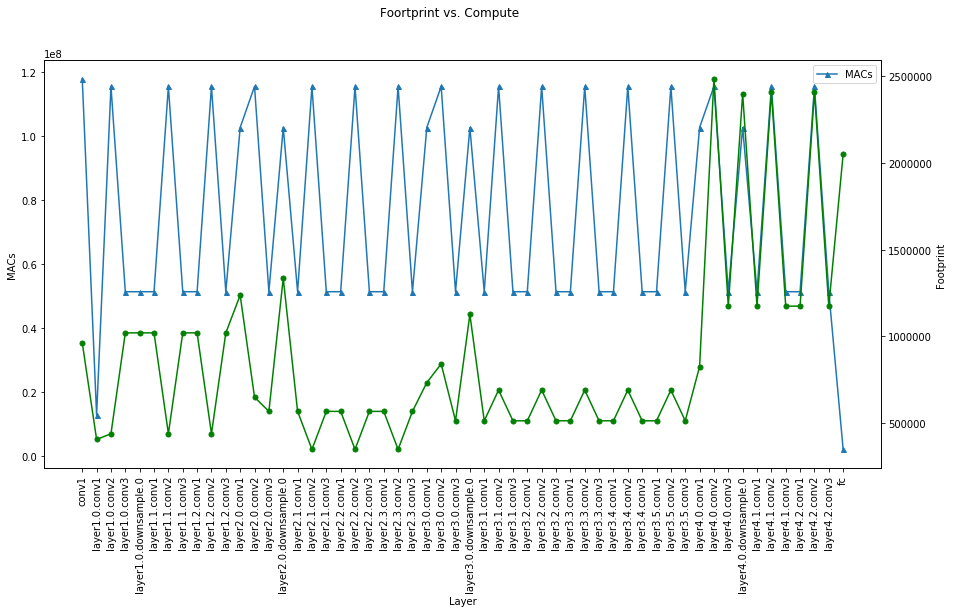

In [12]:
fig, ax = plt.subplots(figsize=(15,7.5))
fig.suptitle("Foortprint vs. Compute")
ax.set_ylabel("MACs")
ax.set_xlabel("Layer")
ax2 = ax.twinx()
ax2.set_ylabel("Footprint")

# df[["Name", "MACs"]].plot(ax=ax, kind='bar', rot=90,  xticks=range(len(df.index)), figsize=[15,7.5])
df[["Name", "MACs"]].plot(ax=ax, rot=90, marker="^", markersize=5, xticks=range(len(df.index)), figsize=[15,7.5])
ax.set_xticklabels(df.Name, rotation=90);

df2 = df["Weights volume"] + df["OFM volume"] + df["IFM volume"]
df2.plot(ax=ax2, style="g-", marker="o", markersize=5, use_index=True, rot=90);

## Filter L1-norm

Draw the L1 norm of each filter, in a selected weight tensor.<br>
When ranking filters by L1-norm (as in [Pruning filters for efficient convnets](#Hao-et-al-2016)), this can provide some insight as to which filters will be removed.<br>
Make sure you've loaded a pretrained network, otherwise you will be looking at random data.

In [13]:
params_names = conv_param_names(model)

def view_weights(pname, sort):
    param = model.state_dict()[pname]
    view_filters = param.view(param.size(0), -1)
    filter_mags = to_np(view_filters.abs().mean(dim=1))
    if sort:
        filter_mags = np.sort(filter_mags)
    plt.figure(figsize=[15,7.5])
    plt.plot(range(len(filter_mags)), filter_mags, label=pname, marker="o", markersize=5, markerfacecolor="C1")
    plt.xlabel('Filter index (i.e. output feature-map channel)')
    plt.ylabel('Fliter L1-norm')

sort_choice = widgets.Checkbox(value=True, description='Sort filters')
params_dropdown = widgets.Dropdown(description='Weights:', options=params_names, layout=Layout(width='40%'))
interact(view_weights, pname=params_dropdown, sort=sort_choice);

interactive(children=(Dropdown(description='Weights:', layout=Layout(width='40%'), options=('conv1.weight', 'layer1.0.conv1.weight', 'layer1.0.conv2.weight', 'layer1.0.conv3.weight', 'layer1.0.downsample.0.weight', 'layer1.1.conv1.weight', 'layer1.1.conv2.weight', 'layer1.1.conv3.weight', 'layer1.2.conv1.weight', 'layer1.2.conv2.weight', 'layer1.2.conv3.weight', 'layer2.0.conv1.weight', 'layer2.0.conv2.weight', 'layer2.0.conv3.weight', 'layer2.0.downsample.0.weight', 'layer2.1.conv1.weight', 'layer2.1.conv2.weight', 'layer2.1.conv3.weight', 'layer2.2.conv1.weight', 'layer2.2.conv2.weight', 'layer2.2.conv3.weight', 'layer2.3.conv1.weight', 'layer2.3.conv2.weight', 'layer2.3.conv3.weight', 'layer3.0.conv1.weight', 'layer3.0.conv2.weight', 'layer3.0.conv3.weight', 'layer3.0.downsample.0.weight', 'layer3.1.conv1.weight', 'layer3.1.conv2.weight', 'layer3.1.conv3.weight', 'layer3.2.conv1.weight', 'layer3.2.conv2.weight', 'layer3.2.conv3.weight', 'layer3.3.conv1.weight', 'layer3.3.conv2.weight', 'layer3.3.conv3.weight', 'layer3.4.conv1.weight', 'layer3.4.conv2.weight', 'layer3.4.conv3.weight', 'layer3.5.conv1.weight', 'layer3.5.conv2.weight', 'layer3.5.conv3.weight', 'layer4.0.conv1.weight', 'layer4.0.conv2.weight', 'layer4.0.conv3.weight', 'layer4.0.downsample.0.weight', 'layer4.1.conv1.weight', 'layer4.1.conv2.weight', 'layer4.1.conv3.weight', 'layer4.2.conv1.weight', 'layer4.2.conv2.weight', 'layer4.2.conv3.weight'), value='conv1.weight'), Checkbox(value=True, description='Sort filters'), Output()), _dom_classes=('widget-interact',))

## Sensitivity Analysis

You prepare a sensitivity analysis file by invoking ```distiller.perform_sensitivity_analysis()```.  Checkout the documentation of ```distiller.perform_sensitivity_analysis()``` for more information.<br>

Alternatively, you can use the sample ```compress_classifier.py``` application to perform sensitivity analysis on one of the supported models.  In the example below, we invoke sensitivity analysis on a pretrained Resnet50 from torchvision using the ImageNet test dataset for evaluation. ***NOTE:*** *When using this approach, an error may occur is data is not in proper format.  Instructions from [GitHub: fb.resnet.torch/INSTALL.md](https://github.com/facebook/fb.resnet.torch/blob/master/INSTALL.md#download-the-imagenet-dataset) were used to format the ImageNet dataset properly.*<br>

Example pruning sensitivity analysis on several different networks are available in ```distiller/examples/sensitivity-analysis``` 

Tensorboard should be launched in the ```distiller/examples/classifier_compression``` directory using:
```tensorboard --logdir='./logs'```

In [14]:
## This block was ran outside of notebook
# comp_class_dir = '/home/cwlacewe/repo/distiller/examples/classifier_compression'  # '../examples/classifier_compression'
# os.chdir(comp_class_dir)

# %run -i compress_classifier.py -a resnet50 /data/datasets/imagenet_jpeg/ilsvrc2012/torchvision -j 12 --pretrained --sense=element
# os.chdir(exp_dir)

After running the above, a sensitivity report is provided in ```../examples/classifier_compression/```.  I renamed the files and moved them to this folder.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout
df_element = pd.read_csv('sensitivity-analysis/sensitivity_resnet50.csv')
df_element['sparsity'] = round(df_element['sparsity'], 2)

The code below converts the sensitivities dataframe to a sensitivities dictionary. 
Using this dictionary makes it easier for us when we want to plot sensitivities.

In [16]:
from collections import OrderedDict

def get_param_names(df):
    return list(set(df['parameter']))

def get_sensitivity_levels(df):
    return list(set(df['sparsity']))

def df2sensitivities(df):
    param_names = get_param_names(df)
    sparsities = get_sensitivity_levels(df)

    sensitivities = {}
    for param_name in param_names:
        sensitivities[param_name] = OrderedDict()
        param_stats = df[(df.parameter == param_name)]
        
        for row in range(len(param_stats.index)):
            s = param_stats.iloc[[row]].sparsity
            top1 = param_stats.iloc[[row]].top1
            top5 = param_stats.iloc[[row]].top5
            sensitivities[param_name][float(s)] = (float(top1), float(top5))
    return sensitivities 

### Examine parameters sensitivities

After loading the sensitivity analysis CSV file into a Pandas dataframe, we can examine it by plotting layer sensitivities at a selected sparsity level. <br>
Use the dropdown to choose the sparsity level, and select whether you choose to view the top1 or top5 accuracies.<br>
Under the plot we display the numerical values of the accuracies, in case you want to have a closer look at the details.

In [17]:
def view2(level, acc):
    filtered = df_element[df_element.sparsity == level]
    s = filtered.style.apply(highlight_min_max)
    
    param_names = filtered['parameter']
    
    # Plot the sensitivities
    x = range(filtered[acc].shape[0])
    y = filtered[acc].values.tolist()
    fig = plt.figure(figsize=(20,10))
    plt.plot(x, y, label=param_names, marker="o", markersize=10, markerfacecolor="C1")
    plt.ylabel(str(acc))
    plt.xlabel('parameter')
    plt.xticks(rotation='vertical')
    plt.xticks(x, param_names)
    plt.title('Pruning Sensitivity per layer %d' % level)    
    #return s

def highlight_min_max(s):
    """Highlight the max and min values in the series"""
    if s.name not in ['top1', 'top5']:
        return ['' for v in s] 
    
    is_max = s == s.max()
    maxes = ['background-color: green' if v else '' for v in is_max]
    is_min = s == s.min()
    mins = ['background-color: red' if v else '' for v in is_min]    
    return [h1 if len(h1)>len(h2) else h2 for (h1,h2) in zip(maxes, mins)]

def view_sparsity(param_name):
    display(df_element[df_element['parameter']==param_name])

In [18]:
sparsities = np.sort(get_sensitivity_levels(df_element))
acc_radio = widgets.RadioButtons(options=['top1', 'top5'], value='top1', description='Accuracy:')
levels_dropdown = widgets.Dropdown(description='Sparsity:', options=sparsities)
interact(view2, level=levels_dropdown, acc=acc_radio);

interactive(children=(Dropdown(description='Sparsity:', options=(0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9), value=0.0), RadioButtons(description='Accuracy:', options=('top1', 'top5'), value='top1'), Output()), _dom_classes=('widget-interact',))

In [19]:
# Sensitivities os specific weight tensor
param_names = sorted(df_element['parameter'].unique().tolist())
param_dropdown = widgets.Dropdown(description='Parameter:', options=param_names)
interact(view_sparsity, param_name=param_dropdown);

interactive(children=(Dropdown(description='Parameter:', options=('module.conv1.weight', 'module.fc.weight', 'module.layer1.0.conv1.weight', 'module.layer1.0.conv2.weight', 'module.layer1.0.conv3.weight', 'module.layer1.0.downsample.0.weight', 'module.layer1.1.conv1.weight', 'module.layer1.1.conv2.weight', 'module.layer1.1.conv3.weight', 'module.layer1.2.conv1.weight', 'module.layer1.2.conv2.weight', 'module.layer1.2.conv3.weight', 'module.layer2.0.conv1.weight', 'module.layer2.0.conv2.weight', 'module.layer2.0.conv3.weight', 'module.layer2.0.downsample.0.weight', 'module.layer2.1.conv1.weight', 'module.layer2.1.conv2.weight', 'module.layer2.1.conv3.weight', 'module.layer2.2.conv1.weight', 'module.layer2.2.conv2.weight', 'module.layer2.2.conv3.weight', 'module.layer2.3.conv1.weight', 'module.layer2.3.conv2.weight', 'module.layer2.3.conv3.weight', 'module.layer3.0.conv1.weight', 'module.layer3.0.conv2.weight', 'module.layer3.0.conv3.weight', 'module.layer3.0.downsample.0.weight', 'module.layer3.1.conv1.weight', 'module.layer3.1.conv2.weight', 'module.layer3.1.conv3.weight', 'module.layer3.2.conv1.weight', 'module.layer3.2.conv2.weight', 'module.layer3.2.conv3.weight', 'module.layer3.3.conv1.weight', 'module.layer3.3.conv2.weight', 'module.layer3.3.conv3.weight', 'module.layer3.4.conv1.weight', 'module.layer3.4.conv2.weight', 'module.layer3.4.conv3.weight', 'module.layer3.5.conv1.weight', 'module.layer3.5.conv2.weight', 'module.layer3.5.conv3.weight', 'module.layer4.0.conv1.weight', 'module.layer4.0.conv2.weight', 'module.layer4.0.conv3.weight', 'module.layer4.0.downsample.0.weight', 'module.layer4.1.conv1.weight', 'module.layer4.1.conv2.weight', 'module.layer4.1.conv3.weight', 'module.layer4.2.conv1.weight', 'module.layer4.2.conv2.weight', 'module.layer4.2.conv3.weight'), value='module.conv1.weight'), Output()), _dom_classes=('widget-interact',))

### Compare layer sensitivities

Plot the pruning sensitivities of selected layers.
<br>Select multiple parameters using SHIFT and CTRL.

In [20]:
# assign a different color to each parameter (otherwise, colors change on us as we make different selections)
color_idx = np.linspace(0, 1, len(param_names))
colors = {}  
for i, pname in zip(color_idx, param_names):
    colors[pname] = color= plt.get_cmap('tab20')(i)
plt.rcParams.update({'font.size': 18})

def view(weights='', acc=0):
    sensitivities= None
    if weights[0]=='All':
        sensitivities = df2sensitivities(df_element)
    else:
        mask = False
        mask = [(df_element.parameter == pname) for pname in weights]
        mask = np.logical_or.reduce(mask)
        sensitivities = df2sensitivities(df_element[mask])


    # Plot the sensitivities
    fig = plt.figure(figsize=(20,10))
    for param_name, sensitivity in sensitivities.items():
        sense = [values[acc] for sparsity, values in sensitivity.items()]
        sparsities = [sparsity for sparsity, values in sensitivity.items()]
        plt.plot(sparsities, sense, label=param_name, marker="o", markersize=10, color=colors[param_name])

    plt.ylabel('top1')
    plt.xlabel('sparsity')
    plt.title('Pruning Sensitivity')
    #plt.legend(loc='lower center', ncol=2, mode="expand", borderaxespad=0.);
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

items = ['All']+param_names
w = widgets.SelectMultiple(options=items, value=[items[1]], layout=Layout(width='50%'), description='Weights:')
acc_widget = widgets.RadioButtons(options={'top1': 0, 'top5': 1}, value=0, description='Accuracy:')
interactive(view, acc=acc_widget, weights=w)

interactive(children=(SelectMultiple(description='Weights:', index=(1,), layout=Layout(width='50%'), options=('All', 'module.conv1.weight', 'module.fc.weight', 'module.layer1.0.conv1.weight', 'module.layer1.0.conv2.weight', 'module.layer1.0.conv3.weight', 'module.layer1.0.downsample.0.weight', 'module.layer1.1.conv1.weight', 'module.layer1.1.conv2.weight', 'module.layer1.1.conv3.weight', 'module.layer1.2.conv1.weight', 'module.layer1.2.conv2.weight', 'module.layer1.2.conv3.weight', 'module.layer2.0.conv1.weight', 'module.layer2.0.conv2.weight', 'module.layer2.0.conv3.weight', 'module.layer2.0.downsample.0.weight', 'module.layer2.1.conv1.weight', 'module.layer2.1.conv2.weight', 'module.layer2.1.conv3.weight', 'module.layer2.2.conv1.weight', 'module.layer2.2.conv2.weight', 'module.layer2.2.conv3.weight', 'module.layer2.3.conv1.weight', 'module.layer2.3.conv2.weight', 'module.layer2.3.conv3.weight', 'module.layer3.0.conv1.weight', 'module.layer3.0.conv2.weight', 'module.layer3.0.conv3.weight', 'module.layer3.0.downsample.0.weight', 'module.layer3.1.conv1.weight', 'module.layer3.1.conv2.weight', 'module.layer3.1.conv3.weight', 'module.layer3.2.conv1.weight', 'module.layer3.2.conv2.weight', 'module.layer3.2.conv3.weight', 'module.layer3.3.conv1.weight', 'module.layer3.3.conv2.weight', 'module.layer3.3.conv3.weight', 'module.layer3.4.conv1.weight', 'module.layer3.4.conv2.weight', 'module.layer3.4.conv3.weight', 'module.layer3.5.conv1.weight', 'module.layer3.5.conv2.weight', 'module.layer3.5.conv3.weight', 'module.layer4.0.conv1.weight', 'module.layer4.0.conv2.weight', 'module.layer4.0.conv3.weight', 'module.layer4.0.downsample.0.weight', 'module.layer4.1.conv1.weight', 'module.layer4.1.conv2.weight', 'module.layer4.1.conv3.weight', 'module.layer4.2.conv1.weight', 'module.layer4.2.conv2.weight', 'module.layer4.2.conv3.weight'), value=('module.conv1.weight',)), RadioButtons(description='Accuracy:', options={'top1': 0, 'top5': 1}, value=0), Output()), _dom_classes=('widget-interact',))

## Prune Network (element-wise) by 40%
Using the graph above, we will prune each network by 40% using the magnitude pruner.

In [21]:
distiller.sparsity(model.state_dict()['conv1.weight'])

0.0

In [22]:
distiller.density(model.state_dict()['conv1.weight'])

1.0

In [23]:
# MagnitudePruner: CMD Line
# time python3 examples/classifier_compression/compress_classifier.py -a resnet50 /data/datasets/imagenet_jpeg/ilsvrc2012/torchvision -j 4 --pretrained --compress=cwl_experiments/sensitivity-analysis/resnet50.schedule_magnitude.yaml --gpus=2
# Unsuccessful

In [ ]:
# SensitivityPruner: CMD Line
# Hardcoded-values to 40% to mimic MgnitudePruner
# time CUDA_VISIBLE_DEVICES=2 python3 examples/classifier_compression/compress_classifier.py -a resnet50 /data/datasets/imagenet_jpeg/ilsvrc2012/torchvision -j 4 --pretrained --compress=cwl_experiments/sensitivity-analysis/resnet50.schedule_sensitivity_direct.yaml
# Unsuccessful

## References

<div id="Gray-et-al-2015"></div> **Andrew Lavin and Scott Gray**. 
    [*Fast Algorithms for Convolutional Neural Networks*](https://arxiv.org/pdf/1509.09308.pdf),
    2015.
<div id="Hao-et-al-2016"></div> **Hao Li, Asim Kadav, Igor Durdanovic, Hanan Samet, and Hans Peter Graf**. 
    [*Pruning filters for efficient convnets*](https://arxiv.org/abs/1608.08710),
    2016.